# Model drop-out by education (bayesian way)

We know how many students dropped out from education before 2016.

To better understand how these vary with the type of education at entry in upper secondary degree, here we estimate a model in a bayesian framework. With non informative priors.

The advantage of this approach is that:

- you can use probability statements (for example: what is the probability that the drop-out rate of students in Three years VET is higher than that one of Specialized schools?)
- natural to model multilevel structures (such as LABB and educational data).
- possibility to model process generating missing informations.

We load the necessary packages:

In [23]:
library(rethinking)
library(viridis)
library(ggridges)
library(magrittr) # necessary
library(dplyr)    # necessary
library(tidyr)    # necessary
library(sqldf)    # necessary
library(repr)

# Change plot size to 4 x 3
options(repr.plot.width=9, repr.plot.height=5)

First we :
- compute the dependent variable and the regressors corresponding to each category of the fsii_e_educType3 
- create a little dataset containing the variables * select a random sample (to speed computations

In [6]:
eq1 <- readRDS(file = "erfolg_quote.rds")
eq1 <- data.frame(eq1)
ex <- eq1 %>% select(cert_det, fsii_e_eductype3)
ex$y <- ifelse(ex$cert_det =="Left edu. < 2016", 1, 0)
ex$twovet <- ifelse(ex$fsii_e_eductype3 == "Two years VET", 1, 0)
ex$threevet <- ifelse(ex$fsii_e_eductype3 == "Three years VET", 1, 0)
ex$fourvet <-  ifelse(ex$fsii_e_eductype3 == "Four years VET", 1, 0)
ex$ecg <- ifelse(ex$fsii_e_eductype3 == "Specialized schools", 1, 0)
ex$gm <- ifelse(ex$fsii_e_eductype3 == "Baccalaureate schools", 1, 0)

ex <- ex %>% select(y, twovet, threevet, fourvet, ecg, gm)

set.seed(1234567) # for reproducibility
ex1 <- ex[sample(nrow(ex), 20000), ]
ex1 <- data.frame(ex1)

We model dropout rates using quadratic approximation:

In [7]:
mod1 <- map(
  alist(
    y ~ dbinom(1, p), 
    logit(p) <- a + b1 * twovet + b2 * threevet + b3 * ecg + b4 * fourvet, 
    a ~ dnorm(0, 10), 
    b1 ~ dnorm(0, 10),
    b2 ~ dnorm(0, 10),
    b3 ~ dnorm(0, 10),
    b4 ~ dnorm(0, 10)
    ),
  data = ex1)

In [9]:
precis(mod1, digits = 3) 

     Mean StdDev   5.5%  94.5%
a  -3.968  0.104 -4.134 -3.802
b1  1.980  0.145  1.748  2.212
b2  1.288  0.112  1.109  1.467
b3  0.959  0.191  0.654  1.264
b4  0.889  0.133  0.676  1.101

We sample from the posterior distribution of the model coefficients and compute predicted probabilities:

In [10]:
post <- extract.samples(mod1)
post <- data.frame(post)
head(post)

a,b1,b2,b3,b4
-3.943631,1.896254,1.226527,0.9526979,0.8889110
-3.970739,2.080407,1.298277,1.0276006,0.8828355
-4.135132,2.154410,1.444016,1.1198803,0.9572146
-3.914690,1.827533,1.283475,0.8500914,0.8086056
-3.944487,1.954921,1.213719,1.0176657,1.1454985
-4.081451,2.068869,1.419065,1.1499007,0.8581667


In [11]:
drop_out_mg <- logistic(post$a)
drop_out_twovet <- logistic(post$a + post$b1)
drop_out_threevet <- logistic(post$a + post$b2)
drop_out_ecg <- logistic(post$a + post$b3)
drop_out_fourvet <- logistic(post$a + post$b4)

In [12]:
data_dens <- data.frame(Formation=rep(c("Baccalaureate schools", 
                                        "Specialized schools", "Two years VET","Three years VET",
                                        "Four years VET"), each=length(drop_out_mg)), 
                        Post_prob_dropout = c(drop_out_mg, drop_out_ecg, drop_out_twovet, drop_out_threevet, drop_out_fourvet))



In [13]:
data_dens %>%
  group_by(Formation) %>%
  summarise(`25%`=quantile(Post_prob_dropout, probs=0.025),
            `50%`=quantile(Post_prob_dropout, probs=0.5),
            `75%`=quantile(Post_prob_dropout, probs=0.975),
            avg=mean(Post_prob_dropout),
            n=n())

Formation,25%,50%,75%,avg,n
Baccalaureate schools,0.01518795,0.01857953,0.02266272,0.01866581,10000
Four years VET,0.03760898,0.04394039,0.05124408,0.04406887,10000
Specialized schools,0.03465398,0.04709698,0.06368597,0.04762544,10000
Three years VET,0.05934260,0.06416860,0.06919463,0.06421055,10000
Two years VET,0.10116522,0.12050687,0.14378536,0.12100295,10000


Picking joint bandwidth of 0.000736


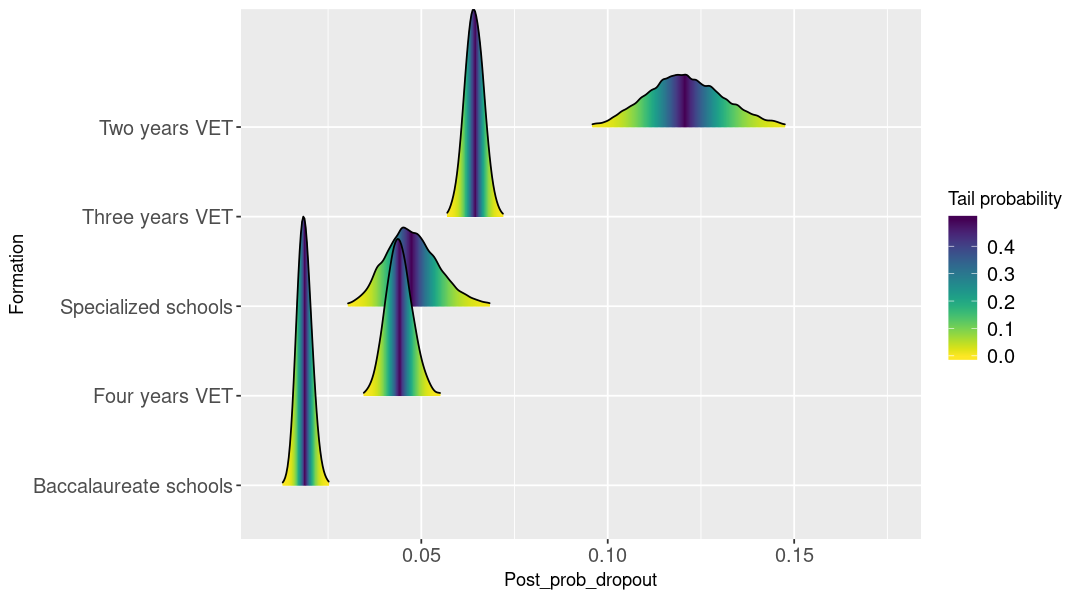

In [24]:
ggplot(data_dens, aes(x=Post_prob_dropout, y=Formation, fill=0.5 - abs(0.5-..ecdf..))) +
  stat_density_ridges(geom = "density_ridges_gradient", calc_ecdf = TRUE,  rel_min_height = 0.01, scale=3) +
  scale_fill_viridis(name = "Tail probability", direction = -1) +
  theme(axis.text=element_text(size=12), legend.text=element_text(size=12))

Here we see that the students in two years VET education have higher probability of drop-out rate, whereas for students in general education this probability is much lower. We see that there is a lot more uncertainty in the plausible parameters for the two years VET and students in specialized schools.

Following this approach you can also answer questions by using probability statements.

For example which is the probability that the drop-out rate of the students in three years VET is higher than that of those of the specialised schools:

In [15]:
diff_dropout_tvet_ecg <- drop_out_threevet - drop_out_ecg
sum(diff_dropout_tvet_ecg > 0) / length(diff_dropout_tvet_ecg)

[1] 0.9738

Here we are sure that the difference between dropout rates of students enrolled in three year education is higher than the one of students from specialized schools.

Or you can test a specific hypothesis, like what is the probability that the difference in drop-out rate between students enrolled in four year VET education with respect to students in specialized schools is higher than 2%?

In [17]:
diff_dropout_fvet_ecg <- drop_out_fourvet - drop_out_ecg
(sum(diff_dropout_fvet_ecg > 0.02) / length(diff_dropout_fvet_ecg))*100

[1] 0.05

We can see that there is 0.05% plausibility that the difference in drop-out rates is higher than 2%.

We can also plot de posterior distribution of the differences of between drop-out rates in specialized schools and VET education:

Picking joint bandwidth of 0.00112


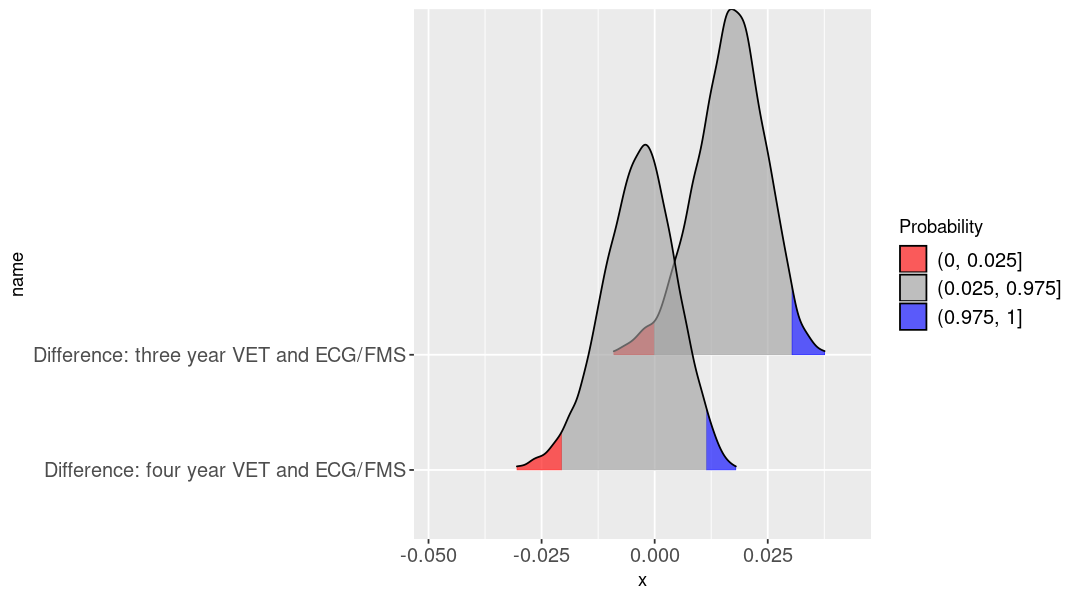

In [25]:
name <- "Difference: three year VET and ECG/FMS"
diff_dropout_tvet_ecg2 <- data.frame(x = diff_dropout_tvet_ecg, name)

name <- "Difference: four year VET and ECG/FMS"
diff_dropout_fvet_ecg2 <- data.frame(x= diff_dropout_fvet_ecg, name)

data_all <- rbind(diff_dropout_fvet_ecg2, diff_dropout_tvet_ecg2)

ggplot(data_all, aes(x=x, y=name, fill=factor(..quantile..))) +
  stat_density_ridges(geom = "density_ridges_gradient", calc_ecdf = TRUE, quantiles = c(0.025, 0.975),
                      rel_min_height = 0.01, scale=3) +
  scale_fill_manual(
    name = "Probability", values = c("#FF0000A0", "#A0A0A0A0", "#0000FFA0"),
    labels = c("(0, 0.025]", "(0.025, 0.975]", "(0.975, 1]")
  ) +
  theme(axis.text=element_text(size=12), legend.text=element_text(size=12))

As for the difference between three years VET and specialized schools, there is 98% probability that this difference is greater than 0. Concerning the difference between four years VET and specialized schools, here we see that 95% of the difference is between -0.02 and 0.012 and that the probability distribution does not even touch the value of 2%.